# Stock Price Movement Prediction using Supervised Machine Learning

In this project, we will use historical stock price data, and build a machine learning pipeline to predict if a stock price will increase or decrease over a specified period.

## Set up Environment and Install relevant libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## Data Collection

In [6]:
df = yf.download("AMZN",
                 start="2015-01-01",
                 end="2025-11-12")

[*********************100%***********************]  1 of 1 completed


In [7]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2015-01-02 00:00:00+00:00,15.4260,15.4260,15.7375,15.3480,15.6290,55664000
2015-01-05 00:00:00+00:00,15.1095,15.1095,15.4190,15.0425,15.3505,55484000
2015-01-06 00:00:00+00:00,14.7645,14.7645,15.1500,14.6190,15.1120,70380000
2015-01-07 00:00:00+00:00,14.9210,14.9210,15.0640,14.7665,14.8750,52806000
2015-01-08 00:00:00+00:00,15.0230,15.0230,15.1570,14.8055,15.0160,61768000


### Data Preprocessing/Cleaning

In [9]:
df.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
count,2483.000000,2483.000000,2483.000000,2483.000000,2483.000000,2.483000e+03
mean,99.694125,99.694125,100.853573,98.483416,99.722363,7.664769e+07
std,52.836090,52.836090,53.476496,52.203331,52.872632,4.061349e+07
min,14.347500,14.347500,14.539500,14.262500,14.314000,1.762600e+07
25%,48.260250,48.260250,48.577000,47.824251,48.200001,5.119100e+07
50%,94.139999,94.139999,95.089996,93.000000,94.040001,6.569600e+07
75%,152.507248,152.507248,154.385002,150.150002,152.737747,9.053500e+07
max,210.050003,210.050003,212.250000,207.440002,209.720001,4.771220e+08


In [10]:
# Check for null values
df.isna().sum()

Price      Ticker
Adj Close  AMZN      0
Close      AMZN      0
High       AMZN      0
Low        AMZN      0
Open       AMZN      0
Volume     AMZN      0
dtype: int64

## Feature Engineering

Creating features that will be used to predict price movements. These include:
- <b>Daily Returns:</b> Percentage change (increase or decrease) of stock closing prices in a specific period
- <b>Moving averages:</b> Average or mean of closing prices over a specific period of time
- <b>Volatility:</b> Measures the risk or variability of returns. Calculated as the standard deviation of daily returns.

In [13]:
# Calculate the daily return as feature
df['Daily_Return'] = df['Close'].pct_change()

# Calculating short and long term moving averages
df['SMA'] = df['Close'].rolling(window=20, min_periods=1).mean()
df['LMA'] = df['Close'].rolling(window=60, min_periods=1).mean()

# Calculating volatility as a feature
df['Volatility'] = df['Daily_Return'].rolling(window=10, min_periods=1).std()

# Display the Feature Columns
df[['Daily_Return','SMA', 'LMA', 'Volatility']]

Price,Daily_Return,SMA,LMA,Volatility
Ticker,,,,
Date,,,,
2015-01-02 00:00:00+00:00,NaN,15.42600,15.426000,NaN
2015-01-05 00:00:00+00:00,-0.020517,15.26775,15.267750,NaN
2015-01-06 00:00:00+00:00,-0.022833,15.10000,15.100000,0.001638
2015-01-07 00:00:00+00:00,0.010600,15.05525,15.055250,0.018670
2015-01-08 00:00:00+00:00,0.006836,15.04880,15.048800,0.017640
...,...,...,...,...
2024-11-06 00:00:00+00:00,0.038045,190.52250,184.666500,0.025515
2024-11-07 00:00:00+00:00,0.014293,191.69250,185.332334,0.025506


In [14]:
# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)

# Check NaN values have been dropped
df[['Daily_Return','SMA', 'LMA', 'Volatility']].head()

Price,Daily_Return,SMA,LMA,Volatility
Ticker,,,,
Date,,,,
2015-01-06 00:00:00+00:00,-0.022833,15.100000,15.100000,0.001638
2015-01-07 00:00:00+00:00,0.010600,15.055250,15.055250,0.018670
2015-01-08 00:00:00+00:00,0.006836,15.048800,15.048800,0.017640
2015-01-09 00:00:00+00:00,-0.011749,15.015083,15.015083,0.015457
2015-01-12 00:00:00+00:00,-0.018590,14.951571,14.951571,0.014544


### Define Target Variable

Creating a binary target variable ```df['Price_Signal']``` where 1 indicates the price increased and zero if the price decreased

In [17]:
# Checks if yesterday's closing price is greater than today's closing price
df['Price_Signal'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [18]:
df[['Close', 'Price_Signal']].tail()

Price,Close,Price_Signal
Ticker,AMZN,
Date,,
2024-11-06 00:00:00+00:00,207.089996,1
2024-11-07 00:00:00+00:00,210.050003,0
2024-11-08 00:00:00+00:00,208.179993,0
2024-11-11 00:00:00+00:00,206.839996,1
2024-11-12 00:00:00+00:00,208.910004,0


In [19]:
# Drop the last row with NaN target
df.dropna(inplace=True)
# Check for null values
print(f'Null Values: {df['Price_Signal'].isna().sum()}')

Null Values: 0


In [20]:
# Separate features and target
X = df[['Daily_Return', 'SMA', 'LMA', 'Volatility']]
y = df['Price_Signal']

### Train-Test Split

Scaling is crucial for models like Logistic Regression and KNN that rely on distance calculations. This is because financial features like returns and volatility can vary widely in scale, and models like logistic regression and KNN perform better with scaled data.

In [23]:
# Split data to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Checking mean and std deviation before scaling data
print("Training Data Mean (before scaling):", X_train.mean(axis=0))
print("Training Data Std Dev (before scaling):", X_train.std(axis=0))

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Checking mean and std deviation of scaled data
print("Training Data Mean (after scaling):", X_train_scaled.mean(axis=0))
print("Training Data Std Dev (after scaling):", X_train_scaled.std(axis=0))

Training Data Mean (before scaling): Price         Ticker
Daily_Return             0.001193
SMA                     97.897094
LMA                     96.604722
Volatility               0.018240
dtype: float64
Training Data Std Dev (before scaling): Price         Ticker
Daily_Return             0.020472
SMA                     52.423951
LMA                     52.081198
Volatility               0.010110
dtype: float64
Training Data Mean (after scaling): [ 1.43254584e-17  1.71905501e-16  3.02625308e-16 -1.27138443e-16]
Training Data Std Dev (after scaling): [1. 1. 1. 1.]


### Build the Pipeline

A pipeline is a sequence of steps that you follow to train a model. We will test three models and run cross validation on the models to see which performs best. Cross-validation is a technique used to assess the performance of a machine learning model on unseen data. It helps prevent overfitting, where a model performs well on training data but poorly on new data.

In [26]:
# Define pipeline with scaler and KNN model
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier()
}

# Store cross-validation results
pipeline_results = {}
scaler = StandardScaler()
 
# Loop through models and perform cross-validation
kfold_cv = KFold(n_splits=5, random_state=42, shuffle=True)

for model_name, model in models.items():
    pipeline = Pipeline([
        ('scaler', scaler),
        ('classifier', model)
    ])
    
    # Cross-validation score for each model
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold_cv, scoring='accuracy')
    pipeline_results[model_name] = cv_scores
    print(f"{model_name}: Mean Accuracy = {cv_scores.mean():.3f}, Standard Deviation = {cv_scores.std():.3f}")


KNN: Mean Accuracy = 0.495, Standard Deviation = 0.031
Logistic Regression: Mean Accuracy = 0.524, Standard Deviation = 0.028
Decision Tree: Mean Accuracy = 0.491, Standard Deviation = 0.023


From the cross validation results, logistic regression demonstates the best performance as the  mean indicates it performs better on average across different folds and the standard deviation is still relatively low suggesting consistent performance.

## Visualise Model Performance

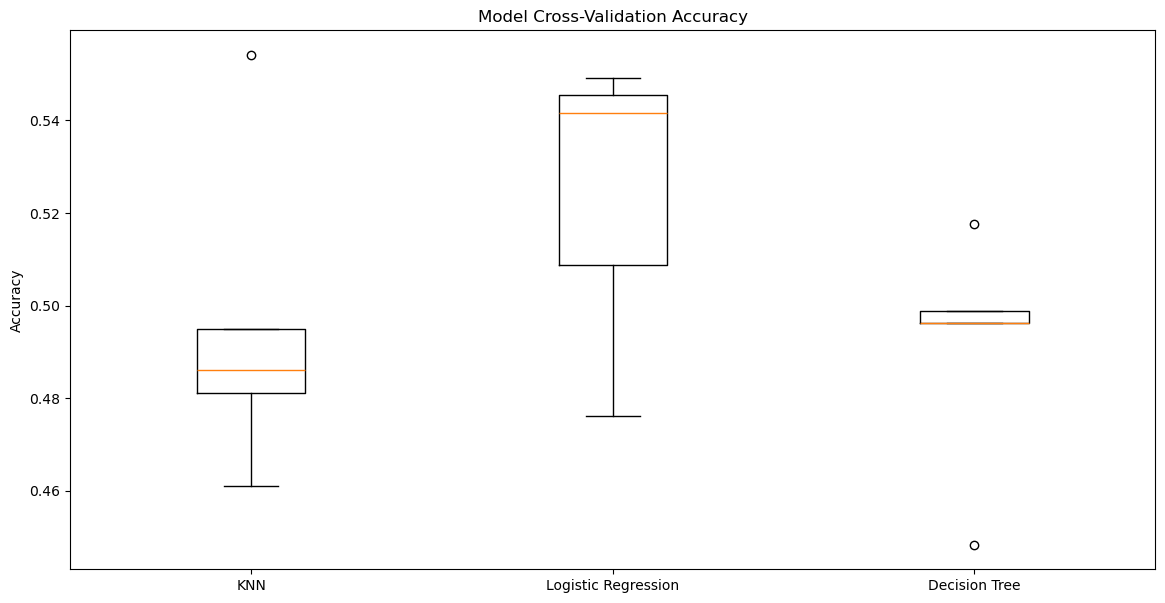

In [29]:
plt.figure(figsize=(14,7))
plt.boxplot(pipeline_results.values(), tick_labels=pipeline_results.keys())
plt.title('Model Cross-Validation Accuracy')
plt.ylabel('Accuracy')
plt.show()

## Model Selection and Evaluation on Test Set

In [31]:
# Choose the best model based on cross-validation results (i.e. Logistic Regression)
best_model = LogisticRegression(max_iter=1000)
pipeline = Pipeline([
    ('scaler', scaler),
    ('classifier', best_model)
])

# Fit on the training data and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5332


## Hyperparameter Tuning

Hyperparameter tuning is the process of optimising the hyperparameters of a machine learning model to improve its performance. Hyperparameters are settings that are not learned from the data but are set before training.

In [34]:
# Define parameter grid for tuning Logistic Regression within the pipeline
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10], 
}
 
# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
 
# Best parameters and test set performance
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.3f}")

Best Parameters: {'classifier__C': 0.01}
Best Cross-Validation Accuracy: 0.534


## Final Model Evaluation

Evaluating the hyperparameter tuned model on the test set

In [37]:
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy after hyperparameter tuning: {test_accuracy:.3f}")

Test Accuracy after hyperparameter tuning: 0.537


# Conclusion

The test accuracy of 0.537 indicates that the model, after hyperparameter tuning, correctly predicts the label (i.e 'Price Signal') for approximately 53.7% of the test data points.